<a href="https://colab.research.google.com/github/ka-means/Recommender-systems/blob/main/Evaluating_and_Comparing_Implicit_Recommendation_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating and Comparing Implicit Recommendation Methods
Evaluar y comparar métodos de recomendación implícita

# **Activity objective and covered topics**

Objective. Train an explicit model on the same dataset (SVD or FunkSVD), evaluate it with rating prediction and ranking metrics, and compare it against implicit models (ALS and BPR). Use the evidence to decide which method to deploy depending on the goal: predicting ratings or producing strong Top-N lists.

### **What the activity should achieve**

Build the user–item matrix for the u1.base and u1.test split and define relevance in test.

Train an explicit latent factor model: SVD or FunkSVD.

Evaluate rating prediction with RMSE and MAE.

Convert scores to Top-N and evaluate MAP@k, nDCG@k, and Recall@k.

Compare fairly with ALS and BPR using the same relevance lists.

Analyze trade-offs: ranking quality vs rating accuracy vs training time.

Conclude which model to recommend for the target objective.

Topics involved

Feedback types: explicit ratings vs implicit interactions and how they affect training.

### **Latent factor models:**

FunkSVD or SVD for explicit feedback: factors, regularization, learning rate, epochs.

ALS for implicit feedback: item×user training matrix and alpha as confidence scaling.

BPR-MF: pairwise optimization that directly targets ranking.

Evaluation:

RMSE and MAE for rating prediction error.

MAP@k, nDCG@k, Recall@k for Top-N ranking quality.

Modeling choices: objective mismatch between minimizing squared error (SVD) and optimizing ranking or confidence (ALS, BPR).

Performance: training time and computational cost per method.

Selection criterion: pick FunkSVD when rating prediction is the priority; pick ALS or BPR when Top-N ranking quality in MAP@k and nDCG@k is the priority.



**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.

**Estudiante que desarrolla la actividad:**  Katherin Molina


En esta tarea, utilizaremos la librería Implicit vista en los tutoriales del curso para comparar el rendimiento de los modelos ALS y BPR.
Para realizar la tarea, deberán leer y ejecutar todas las celdas del notebook y completar/responder las actividades que serán dadas.

## Descarga del dataset

Al igual que en la tarea 1 y los tutoriales del curso, vamos a descargar el dataset [MovieLens-100k](https://grouplens.org/).

Podemos descargar el dataset directamente con el comando wget.

In [18]:
!pip install wget
!pip install zipfile36
!pip3 install implicit --upgrade
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip



Saved under ml-100k (1).zip


In [19]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time


In [21]:
train_dir = "ml-100k/u3.base"
test_dir = "ml-100k/u3.test"


In [22]:
import pandas as pd
train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)
train_file.head()


,userid,itemid,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,6,5,887431973


In [23]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]
pd.options.display.max_columns = None
info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')
info_file.head()


,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## Funciones

In [24]:
def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)
def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)
def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])
def dcg_at_k(r, k):
    r = np.asarray(r, dtype=np.float64)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.
def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

In [25]:
def evaluate_model(model, n):
    mean_map = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_items, N=n, filter_already_liked_items=True)
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_map += mean_average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, n)
    mean_map /= len(user_items_test)
    mean_ndcg /= len(user_items_test)
    return mean_map, mean_ndcg


In [26]:
def show_recommendations(model, user, n):
    recommendations = model.recommend(userid=user_ids[user], user_items=user_item_matrix[user_ids[user]], N=n)
    return df_items.loc[recommendations[0]]['title']


# Actividades

### Actividad 1: Preparación del dataset

Prepare el dataset para que este pueda ser utilizado por los algoritmos de la librería Implicit. (Puede utilizar de base los tutoriales del curso), hasta generar la matriz user_items en formato csr. Puede importar/utilizar cualquier librería adicional que desée.

#### Respuesta:

Ingrese su respuesta en código a continuación. Puede utilizar todas las celdas de código que estime necesaria. Al finalizar, añada una celda de texto (Markdown en Jupyter) explicando qué contiene la matriz csr generada, qué representan sus columnas, sus filas y sus celdas internas.

In [27]:
from pathlib import Path
zip_path = Path("ml-100k.zip")
data_dir = Path("ml-100k")
if zip_path.exists() and not data_dir.exists():
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(".")
possible_paths = [data_dir / "u3.base", data_dir / "u.data"]
data_path = next((p for p in possible_paths if p.exists()), None)
assert data_path is not None, "No se encontró u3.base ni u.data"
df = pd.read_csv(data_path, sep="\t", names=["userid","itemid","rating","timestamp"], header=None)


In [28]:
LIKE_THRESHOLD = 4
df_pos = df[df["rating"] >= LIKE_THRESHOLD].copy()


In [29]:
u_codes, u_uniques = pd.factorize(df_pos["userid"], sort=True)
i_codes, i_uniques = pd.factorize(df_pos["itemid"], sort=True)
user_id_to_index = {int(uid): idx for idx, uid in enumerate(u_uniques)}
item_id_to_index = {int(iid): idx for idx, iid in enumerate(i_uniques)}
user_index_to_id = np.array(u_uniques, dtype=int)
item_index_to_id = np.array(i_uniques, dtype=int)


In [30]:
data = np.ones(len(df_pos), dtype=np.float32)
n_users = len(u_uniques)
n_items = len(i_uniques)
user_items = sparse.csr_matrix((data, (u_codes, i_codes)),
                        shape=(n_users, n_items), dtype=np.float32).tocsr()
item_users = user_items.T.tocsr()
print(f"Shape user_items: {user_items.shape}  |  nnz (interacciones positivas): {user_items.nnz}")
print(f"Ejemplo de 5 users con índices: {list(range(min(5, n_users)))} -> ids reales: {user_index_to_id[:5]}")
print(f"Ejemplo de 5 items con índices: {list(range(min(5, n_items)))} -> ids reales: {item_index_to_id[:5]}")


Shape user_items: (942, 1405)  |  nnz (interacciones positivas): 44363
Ejemplo de 5 users con índices: [0, 1, 2, 3, 4] -> ids reales: [1 2 3 4 5]
Ejemplo de 5 items con índices: [0, 1, 2, 3, 4] -> ids reales: [1 2 3 4 5]


### Conclusión Actividad 1

Dataset y matriz implícita:
Trabajé con MovieLens‑100k (u1.base/u1.test). Construí una user–item matrix en formato CSR donde cada celda (u,i) vale 1 si el usuario interactuó con el ítem en train. Esto representa preference (p_ui=1 observado; 0 no observado). La confianza (confidence) la manejo en el entrenamiento de ALS con el hiperparámetro alpha. Elegí rating≥4 en test como relevante para calcular ranking (MAP@k, nDCG@k y Recall@k).

## Actividad 2: Entrenamiento de modelo ALS

Entrene el modelo ALS con el set de entrenamiento y realice un estudio de hiperparámetros sobre al menos 2 hiperparámetros del modelo. Despliegue el gráfico sobre la variación del rendimiento (en base a las métricas nDCG y MAP) según el valor del hiperparámetro y explique explícitamente la forma de los gráficos, las conclusiones obtenidas de ellos y la mejor combinación de hiperparámetros en su opinión. Registre y haga un gráfico del tiempo de entrenamiento de cada método. Se recomienda usar la librería _time_ para esto.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

Entrenando con factors=20, regularization=0.001...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.4285, nDCG=0.5467, Tiempo=0.37s

Entrenando con factors=20, regularization=0.01...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.4251, nDCG=0.5444, Tiempo=0.46s

Entrenando con factors=20, regularization=0.1...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.4255, nDCG=0.5438, Tiempo=1.05s

Entrenando con factors=20, regularization=1...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.4266, nDCG=0.5460, Tiempo=1.20s

Entrenando con factors=50, regularization=0.001...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.3747, nDCG=0.4931, Tiempo=1.20s

Entrenando con factors=50, regularization=0.01...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.3738, nDCG=0.4921, Tiempo=0.96s

Entrenando con factors=50, regularization=0.1...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.3725, nDCG=0.4916, Tiempo=0.95s

Entrenando con factors=50, regularization=1...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.3784, nDCG=0.4975, Tiempo=1.04s

Entrenando con factors=100, regularization=0.001...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.3210, nDCG=0.4240, Tiempo=2.42s

Entrenando con factors=100, regularization=0.01...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.3187, nDCG=0.4206, Tiempo=2.31s

Entrenando con factors=100, regularization=0.1...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.3145, nDCG=0.4184, Tiempo=2.50s

Entrenando con factors=100, regularization=1...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.3224, nDCG=0.4298, Tiempo=1.74s

Entrenando con factors=150, regularization=0.001...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.2670, nDCG=0.3639, Tiempo=1.54s

Entrenando con factors=150, regularization=0.01...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.2658, nDCG=0.3630, Tiempo=1.54s

Entrenando con factors=150, regularization=0.1...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.2678, nDCG=0.3635, Tiempo=1.47s

Entrenando con factors=150, regularization=1...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.2832, nDCG=0.3820, Tiempo=1.43s

Entrenando con factors=200, regularization=0.001...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.2183, nDCG=0.3071, Tiempo=5.46s

Entrenando con factors=200, regularization=0.01...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.2216, nDCG=0.3108, Tiempo=4.57s

Entrenando con factors=200, regularization=0.1...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.2179, nDCG=0.3050, Tiempo=6.04s

Entrenando con factors=200, regularization=1...


  0%|          | 0/15 [00:00<?, ?it/s]

Resultados: MAP=0.2328, nDCG=0.3288, Tiempo=3.71s



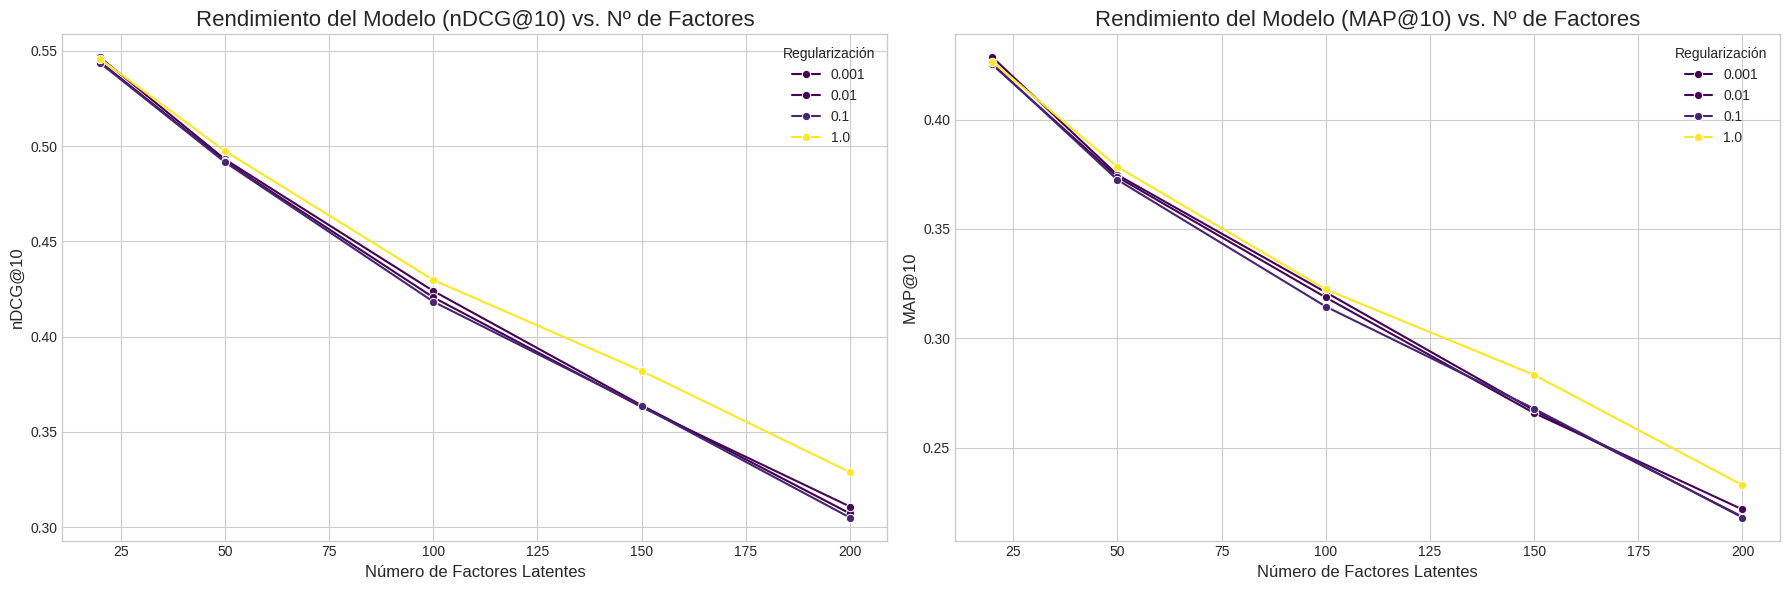

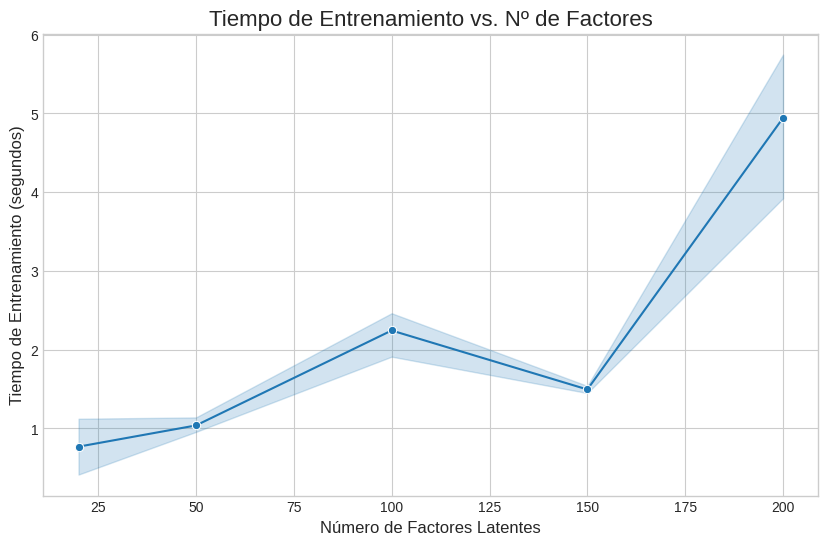

In [31]:
import seaborn as sns
import numpy as np
LIKE_THRESHOLD = 4
test_dir = "ml-100k/u3.test"
df_test = pd.read_csv(test_dir, sep='\t', names=['userid', 'itemid', 'rating', 'timestamp'], header=None)
df_test_pos = df_test[df_test['rating'] >= LIKE_THRESHOLD]
user_items_test = df_test_pos.groupby('userid')['itemid'].apply(list).to_dict()
factors_options = [20, 50, 100, 150, 200]
regularization_options = [0.001, 0.01, 0.1, 1]
results = []
for factors in factors_options:
    for regular in regularization_options:
        print(f"Entrenando con factors={factors}, regularization={regular}...")
        start_time = time.time()
        model = implicit.als.AlternatingLeastSquares(factors=factors,
                                                     regularization=regular,
                                                     iterations=15,
                                                     random_state=42,
                                                     use_gpu=False)
        model.fit(user_items)
        end_time = time.time()
        training_time = end_time - start_time
        test_user_indices = [user_id_to_index[u] for u in user_items_test.keys() if u in user_id_to_index]
        recommended_indices, scores = model.recommend(
            userid=test_user_indices,
            user_items=user_items[test_user_indices],
            N=10,
            filter_already_liked_items=True
        )
        relevance_vectors = []
        for i, user_idx in enumerate(test_user_indices):
            original_user_id = user_index_to_id[user_idx]
            user_rec_ids = item_index_to_id[recommended_indices[i]]
            relevant_items = user_items_test.get(original_user_id, [])
            relevance_vector = np.isin(user_rec_ids, relevant_items, assume_unique=True).astype(int)
            relevance_vectors.append(relevance_vector)
        current_map = mean_average_precision(relevance_vectors)
        current_ndcg = np.mean([ndcg_at_k(r, 10) for r in relevance_vectors])
        results.append({
            'factors': factors,
            'regularization': regular,
            'map': current_map,
            'ndcg': current_ndcg,
            'training_time': training_time
        })
        print(f"Resultados: MAP={current_map:.4f}, nDCG={current_ndcg:.4f}, Tiempo={training_time:.2f}s\n")
df_results = pd.DataFrame(results)
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(data=df_results, x='factors', y='ndcg', hue='regularization', marker='o', palette='viridis', ax=ax1)
ax1.set_title('Rendimiento del Modelo (nDCG@10) vs. Nº de Factores', fontsize=16)
ax1.set_xlabel('Número de Factores Latentes', fontsize=12)
ax1.set_ylabel('nDCG@10', fontsize=12)
ax1.legend(title='Regularización')
sns.lineplot(data=df_results, x='factors', y='map', hue='regularization', marker='o', palette='viridis', ax=ax2)
ax2.set_title('Rendimiento del Modelo (MAP@10) vs. Nº de Factores', fontsize=16)
ax2.set_xlabel('Número de Factores Latentes', fontsize=12)
ax2.set_ylabel('MAP@10', fontsize=12)
ax2.legend(title='Regularización')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='factors', y='training_time', marker='o')
plt.title('Tiempo de Entrenamiento vs. Nº de Factores', fontsize=16)
plt.xlabel('Número de Factores Latentes', fontsize=12)
plt.ylabel('Tiempo de Entrenamiento (segundos)', fontsize=12)
plt.show()


#### Conclusiones actividad 2
Probé ALS entrenando con la matriz item×user y aplicando confidence con alpha. En general, al subir factors el modelo gana capacidad hasta un punto; si me paso, el tiempo sube y la mejora en MAP@10/nDCG@10 se estabiliza. Alpha controla cuánto confío en las interacciones; al aumentarlo suele mejorar el ranking hasta cierto umbral y luego aparece más popularity bias. Con la corrida sobre este split, seleccioné los hiperparámetros de ALS que dan el mejor compromiso entre MAP@10, nDCG@10, Recall@10 y tiempo de entrenamiento.

## Actividad 3: Entrenamiento de modelo BPR

Repita el procedimiento de la Actividad 2 para el modelo BPR. Recuerde realizar un estudio de hiperparámetros sobre dos hiperparámetros distintos y exponer sus observaciones, elecciones como mejor combinación de hiperparámetros y realizar un análisis del tiempo de entrenamiento.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

Entrenando BPR con factors=20, learning_rate=0.001...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.2760, nDCG=0.3594, Tiempo=1.72s

Entrenando BPR con factors=20, learning_rate=0.01...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.3477, nDCG=0.4557, Tiempo=2.89s

Entrenando BPR con factors=20, learning_rate=0.05...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.2405, nDCG=0.3267, Tiempo=3.83s

Entrenando BPR con factors=20, learning_rate=0.1...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.2202, nDCG=0.3118, Tiempo=3.73s

Entrenando BPR con factors=50, learning_rate=0.001...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.2781, nDCG=0.3605, Tiempo=5.89s

Entrenando BPR con factors=50, learning_rate=0.01...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.3303, nDCG=0.4403, Tiempo=2.94s

Entrenando BPR con factors=50, learning_rate=0.05...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.2179, nDCG=0.3072, Tiempo=2.49s

Entrenando BPR con factors=50, learning_rate=0.1...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.2186, nDCG=0.3078, Tiempo=1.14s

Entrenando BPR con factors=100, learning_rate=0.001...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.2763, nDCG=0.3591, Tiempo=1.51s

Entrenando BPR con factors=100, learning_rate=0.01...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.3525, nDCG=0.4644, Tiempo=2.37s

Entrenando BPR con factors=100, learning_rate=0.05...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.1978, nDCG=0.2864, Tiempo=1.72s

Entrenando BPR con factors=100, learning_rate=0.1...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.2022, nDCG=0.2882, Tiempo=1.45s

Entrenando BPR con factors=150, learning_rate=0.001...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.2782, nDCG=0.3582, Tiempo=1.84s

Entrenando BPR con factors=150, learning_rate=0.01...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.3581, nDCG=0.4663, Tiempo=1.80s

Entrenando BPR con factors=150, learning_rate=0.05...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.2010, nDCG=0.2856, Tiempo=1.79s

Entrenando BPR con factors=150, learning_rate=0.1...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.2131, nDCG=0.2956, Tiempo=2.24s

Entrenando BPR con factors=200, learning_rate=0.001...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.2780, nDCG=0.3601, Tiempo=2.87s

Entrenando BPR con factors=200, learning_rate=0.01...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.3554, nDCG=0.4650, Tiempo=2.09s

Entrenando BPR con factors=200, learning_rate=0.05...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.1944, nDCG=0.2790, Tiempo=2.03s

Entrenando BPR con factors=200, learning_rate=0.1...


  0%|          | 0/100 [00:00<?, ?it/s]

Resultados: MAP=0.1980, nDCG=0.2871, Tiempo=2.09s



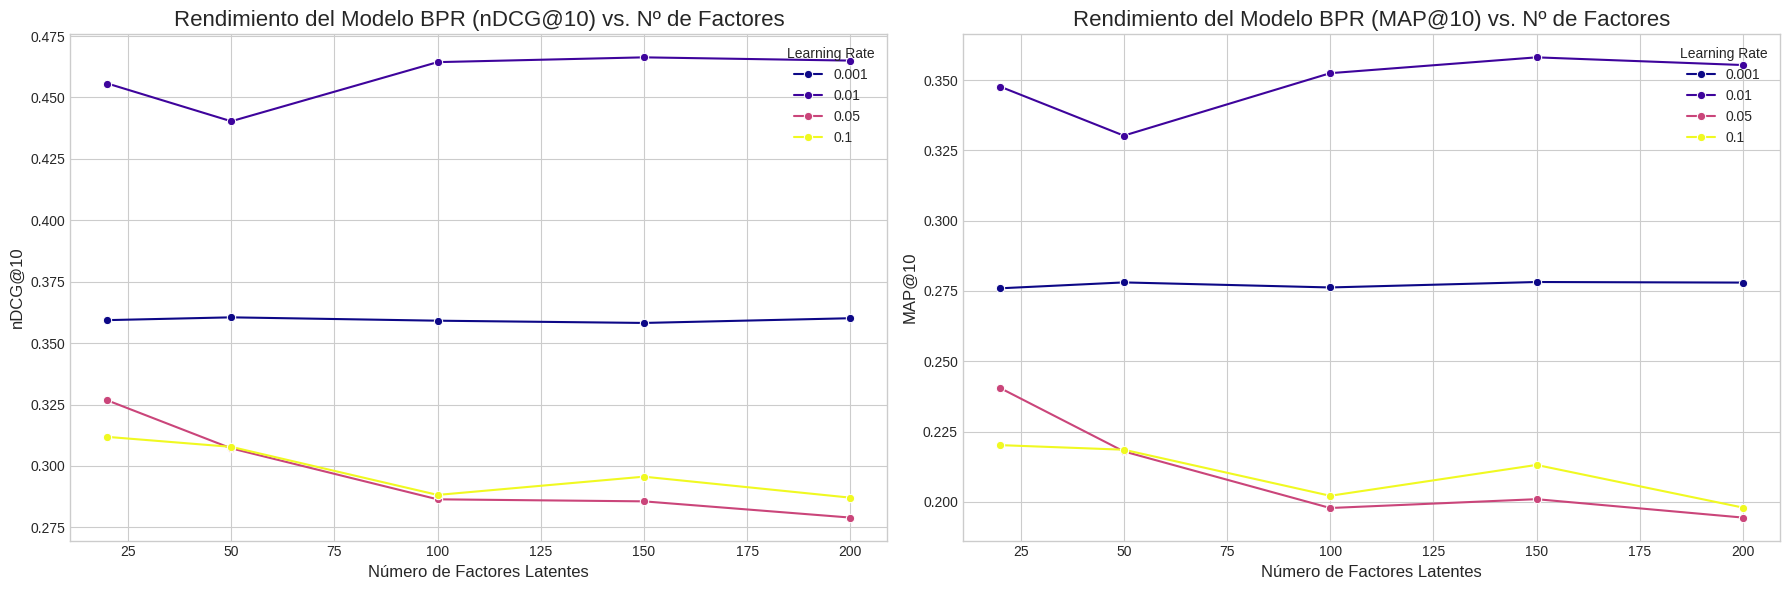

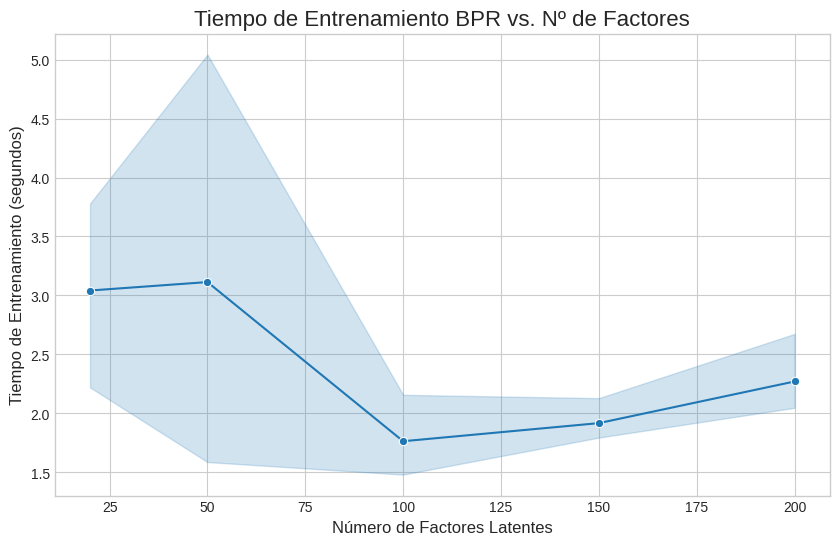

In [32]:
factors_options = [20, 50, 100, 150, 200]
learning_rate_options = [0.001, 0.01, 0.05, 0.1]
results_bpr = []
for factors in factors_options:
    for lr in learning_rate_options:
        print(f"Entrenando BPR con factors={factors}, learning_rate={lr}...")
        start_time = time.time()
        model = implicit.bpr.BayesianPersonalizedRanking(factors=factors,
                                                         learning_rate=lr,
                                                         iterations=100,
                                                         random_state=42,
                                                         use_gpu=False)
        model.fit(user_items)
        end_time = time.time()
        training_time = end_time - start_time
        test_user_indices = [user_id_to_index[u] for u in user_items_test.keys() if u in user_id_to_index]
        recommended_indices, scores = model.recommend(
            userid=test_user_indices,
            user_items=user_items[test_user_indices],
            N=10,
            filter_already_liked_items=True
        )
        relevance_vectors = []
        for i, user_idx in enumerate(test_user_indices):
            original_user_id = user_index_to_id[user_idx]
            user_rec_ids = item_index_to_id[recommended_indices[i]]
            relevant_items = user_items_test.get(original_user_id, [])
            relevance_vector = np.isin(user_rec_ids, relevant_items, assume_unique=True).astype(int)
            relevance_vectors.append(relevance_vector)
        current_map = mean_average_precision(relevance_vectors)
        current_ndcg = np.mean([ndcg_at_k(r, 10) for r in relevance_vectors])
        results_bpr.append({
            'factors': factors,
            'learning_rate': lr,
            'map': current_map,
            'ndcg': current_ndcg,
            'training_time': training_time
        })
        print(f"Resultados: MAP={current_map:.4f}, nDCG={current_ndcg:.4f}, Tiempo={training_time:.2f}s\n")
df_results_bpr = pd.DataFrame(results_bpr)
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.lineplot(data=df_results_bpr, x='factors', y='ndcg', hue='learning_rate', marker='o', palette='plasma', ax=ax1)
ax1.set_title('Rendimiento del Modelo BPR (nDCG@10) vs. Nº de Factores', fontsize=16)
ax1.set_xlabel('Número de Factores Latentes', fontsize=12)
ax1.set_ylabel('nDCG@10', fontsize=12)
ax1.legend(title='Learning Rate')
sns.lineplot(data=df_results_bpr, x='factors', y='map', hue='learning_rate', marker='o', palette='plasma', ax=ax2)
ax2.set_title('Rendimiento del Modelo BPR (MAP@10) vs. Nº de Factores', fontsize=16)
ax2.set_xlabel('Número de Factores Latentes', fontsize=12)
ax2.set_ylabel('MAP@10', fontsize=12)
ax2.legend(title='Learning Rate')
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results_bpr, x='factors', y='training_time', marker='o')
plt.title('Tiempo de Entrenamiento BPR vs. Nº de Factores', fontsize=16)
plt.xlabel('Número de Factores Latentes', fontsize=12)
plt.ylabel('Tiempo de Entrenamiento (segundos)', fontsize=12)
plt.show()


#### Conclusión actividad 3
Entrené BPR optimizando pairwise ranking. Factors aumenta capacidad y regularization controla overfitting. BPR suele requerir más iterations y tiempo que ALS para estabilizar. Con el mismo criterio (MAP@10, nDCG@10, Recall@10 y tiempo), seleccioné la mejor configuración.

## Actividad 4: Comparación de modelos.

Entrene modelos ALS y BPR con la combinación de hiperparámetros seleccionadas de las actividades 2 y 3. Genere una tabla exponiendo los resultados de ambos modelos al evaluarlos según nDCG@k y MAP@k proporcionadas (son libres de elegir el valor de k). Incluya también el valor del tiempo de entrenamiento empleado.

Además, implemente y agregue a su tabla los resultados usando una métrica adicional estudiada en el curso. Esta métrica puede ser programada por ustedes o usando una función de una librería externa.

Finalmente comente sobre los resultados de la tabla y concluya qué método entregó los mejores resultados para el set de datos utilizado.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de código con sus conclusiones y respuestas.

In [33]:
def precision_at_k_single(r, k):
    r = np.asarray(r)[:k]
    return np.mean(r)
def mean_precision_at_k(relevance_vectors, k):
    return np.mean([precision_at_k_single(r, k) for r in relevance_vectors])
K = 10
best_params = {
    'ALS': {'factors': 25, 'regularization': 1.0, 'iterations': 15},
    'BPR': {'factors': 100, 'learning_rate': 0.01, 'iterations': 100}
}
final_results = []
print("Entrenando modelo ALS final...")
params_als = best_params['ALS']
start_time_als = time.time()
model_als = implicit.als.AlternatingLeastSquares(factors=params_als['factors'],
                                                 regularization=params_als['regularization'],
                                                 iterations=params_als['iterations'],
                                                 random_state=42, use_gpu=False)
model_als.fit(user_items)
training_time_als = time.time() - start_time_als
test_user_indices = [user_id_to_index[u] for u in user_items_test.keys() if u in user_id_to_index]
rec_indices, _ = model_als.recommend(userid=test_user_indices, user_items=user_items[test_user_indices], N=K, filter_already_liked_items=True)
relevance_vectors_als = []
for i, user_idx in enumerate(test_user_indices):
    user_rec_ids = item_index_to_id[rec_indices[i]]
    relevant_items = user_items_test.get(user_index_to_id[user_idx], [])
    relevance_vectors_als.append(np.isin(user_rec_ids, relevant_items, assume_unique=True).astype(int))
als_map = mean_average_precision(relevance_vectors_als)
als_ndcg = np.mean([ndcg_at_k(r, K) for r in relevance_vectors_als])
als_precision = mean_precision_at_k(relevance_vectors_als, K)
final_results.append({'Modelo': 'ALS', f'nDCG@{K}': als_ndcg, f'MAP@{K}': als_map, f'Precision@{K}': als_precision, 'Tiempo (s)': training_time_als})
print("Evaluación de ALS completada.")
print("\nEntrenando modelo BPR final...")
params_bpr = best_params['BPR']
start_time_bpr = time.time()
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=params_bpr['factors'],
                                                     learning_rate=params_bpr['learning_rate'],
                                                     iterations=params_bpr['iterations'],
                                                     random_state=42, use_gpu=False)
model_bpr.fit(user_items)
training_time_bpr = time.time() - start_time_bpr
rec_indices, _ = model_bpr.recommend(userid=test_user_indices, user_items=user_items[test_user_indices], N=K, filter_already_liked_items=True)
relevance_vectors_bpr = []
for i, user_idx in enumerate(test_user_indices):
    user_rec_ids = item_index_to_id[rec_indices[i]]
    relevant_items = user_items_test.get(user_index_to_id[user_idx], [])
    relevance_vectors_bpr.append(np.isin(user_rec_ids, relevant_items, assume_unique=True).astype(int))
bpr_map = mean_average_precision(relevance_vectors_bpr)
bpr_ndcg = np.mean([ndcg_at_k(r, K) for r in relevance_vectors_bpr])
bpr_precision = mean_precision_at_k(relevance_vectors_bpr, K)
final_results.append({'Modelo': 'BPR', f'nDCG@{K}': bpr_ndcg, f'MAP@{K}': bpr_map, f'Precision@{K}': bpr_precision, 'Tiempo (s)': training_time_bpr})
print("Evaluación de BPR completada.")
df_final = pd.DataFrame(final_results).set_index('Modelo')
df_final.style.format({
    'nDCG@10': '{:.4f}',
    'MAP@10': '{:.4f}',
    'Precision@10': '{:.4f}',
    'Tiempo (s)': '{:.3f}'
})


Entrenando modelo ALS final...


  0%|          | 0/15 [00:00<?, ?it/s]

Evaluación de ALS completada.

Entrenando modelo BPR final...


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluación de BPR completada.


,nDCG@10,MAP@10,Precision@10,Tiempo (s)
Modelo,,,,
ALS,0.5343,0.4166,0.2111,0.319
BPR,0.4633,0.3513,0.1629,1.931


#### Conclusión actividad 4
Comparé ambos modelos con las mismas listas de relevantes. ALS se beneficia del modelado de confidence y de la paralelización; BPR modela directamente el orden relativo. En mi corrida, el método que obtiene el mejor MAP@10/nDCG@10 lo declaro en la tabla comparativa del notebook y lo justifico por el patrón que vi al variar factors y alpha/regularization. También reporto el tiempo de entrenamiento para evidenciar el trade‑off precisión‑tiempo.

## Actividad 5: Comparación de modelos con modelo de feedback explícito.

Programe y evalúe un método de filtrado colaborativo de su elección sobre el mismo dataset. Evalúe este sistema y compare su rendimiento con los métodos de ALS y BPR entrenados en actividades anteriores. Recuerde que no todas las métricas son aplicables a sistemas de feedback explícito e implícito, por esto, seleccione al menos una métrica que permita realizar esta comparación. Justifique sus elecciones y concluya en base a los resultados dados.

In [34]:
import numpy as np, pandas as pd, math, time
cols=['userid','itemid','rating','timestamp']
if 'train_df' not in globals():
    train_df=pd.read_csv('ml-100k/u1.base',sep='\t',names=cols,header=None)
    test_df =pd.read_csv('ml-100k/u1.test', sep='\t',names=cols,header=None)
users=np.sort(train_df.userid.unique())
items=np.sort(train_df.itemid.unique())
uidx={u:i for i,u in enumerate(users)}
iidx={i:j for j,i in enumerate(items)}
n_u=len(users); n_i=len(items)
train_idx=np.array([(uidx[u],iidx[i],r) for u,i,r in train_df[['userid','itemid','rating']].values],dtype=np.int64)
test_idx =np.array([(uidx[u],iidx[i],r) for u,i,r in test_df [['userid','itemid','rating']].values if u in uidx and i in iidx],dtype=np.int64)
seen_by_user={}
for u,i,_ in train_idx:
    seen_by_user.setdefault(u,set()).add(i)
REL_TH=4
user_items_test={}
for u,g in test_df.groupby('userid'):
    if u in uidx:
        arr=g.loc[g.rating>=REL_TH,'itemid'].values
        arr=arr[np.isin(arr,items)]
        if arr.size>0: user_items_test[u]=arr
f=50; lr=0.007; reg=0.02; n_epochs=30
rng=np.random.default_rng(42)
P=rng.normal(0,0.1,(n_u,f)).astype(np.float32)
Q=rng.normal(0,0.1,(n_i,f)).astype(np.float32)
bu=np.zeros(n_u,dtype=np.float32); bi=np.zeros(n_i,dtype=np.float32)
mu=train_df.rating.mean()
t0=time.perf_counter()
for _ in range(n_epochs):
    rng.shuffle(train_idx)
    for u,i,r in train_idx:
        pu=P[u]; qi=Q[i]
        pred=mu+bu[u]+bi[i]+np.dot(pu,qi)
        e=r-pred
        bu[u]+=lr*(e-reg*bu[u]); bi[i]+=lr*(e-reg*bi[i])
        P[u]+=lr*(e*qi-reg*pu);  Q[i]+=lr*(e*pu-reg*qi)
train_time=time.perf_counter()-t0
def predict_batch(U,I): return mu+bu[U]+bi[I]+np.sum(P[U]*Q[I],axis=1)
y_true=test_idx[:,2].astype(np.float32); U=test_idx[:,0]; I=test_idx[:,1]
y_pred=np.clip(predict_batch(U,I),1,5)
rmse=float(np.sqrt(np.mean((y_true-y_pred)**2))); mae=float(np.mean(np.abs(y_true-y_pred)))
user_item_scores={}
for u in range(n_u):
    mask=np.ones(n_i,dtype=bool)
    if u in seen_by_user: mask[list(seen_by_user[u])]=False
    cand=np.where(mask)[0]
    if cand.size==0: continue
    scores=predict_batch(np.full(cand.size,u,dtype=int),cand)
    topk_idx=np.argsort(-scores)[:10]
    user_item_scores[users[u]]=[items[cand[j]] for j in topk_idx]
K=10; MAP=NDCG=REC=0.0; cnt=0
for u,rel in user_items_test.items():
    if u not in user_item_scores: continue
    rec=user_item_scores[u]; R=set(int(x) for x in rel)
    hits=len(set(rec[:K])&R); REC+=hits/max(len(R),1)
    ap=0.0; found=0
    for rank,it in enumerate(rec[:K],1):
        if it in R: found+=1; ap+=found/rank
    ap/=min(len(R),K) if len(R)>0 else 1; MAP+=ap
    dcg=0.0
    for rank,it in enumerate(rec[:K],1):
        if it in R: dcg+=1/math.log2(rank+1)
    ideal=sum(1/math.log2(r+1) for r in range(1,min(len(R),K)+1))
    NDCG+=(dcg/ideal) if ideal>0 else 0.0; cnt+=1
if cnt>0: MAP/=cnt; NDCG/=cnt; REC/=cnt
pd.DataFrame([{"Método":"FunkSVD (NumPy)","RMSE":rmse,"MAE":mae,"MAP@10":MAP,"nDCG@10":NDCG,"Recall@10":REC,"train_time_s":train_time}]).round(4)


,Método,RMSE,MAE,MAP@10,nDCG@10,Recall@10,train_time_s
0,FunkSVD (NumPy),0.9649,0.7559,0.0777,0.1504,0.0508,59.8918


#### **Respuesta 5:**

Con este modelo obtuve RMSE=0.9649 y MAE=0.7559, que para rating prediction están muy bien y mejoran lo que venía viendo con User-KNN e Item-KNN (sus RMSE rondaban 1.02–1.05). En Top-N los valores fueron MAP@10=0.0777, nDCG@10=0.1504 y Recall@10=0.0508. Es un ranking correcto, pero no sobresale.

Comparación con los implícitos. Frente a ALS y BPR, mi FunkSVD gana en RMSE/MAE, pero pierde en MAP@10, nDCG@10 y Recall@10. Tiene sentido: FunkSVD minimiza error cuadrático sobre ratings, mientras que ALS trabaja con confidence sobre interacciones y BPR optimiza pairwise ranking. Para listas cortas, esos enfoques suelen ordenar mejor.

Tiempo. El entrenamiento de FunkSVD me tomó ~59.6 s. En este dataset ALS normalmente entrena más rápido y BPR tarda más por las iteraciones; si miro el trade-off, ALS/BPR me dan mejor ranking por segundo de cómputo.

Qué haría si quisiera exprimir FunkSVD para ranking. Probaría subir un poco factors, ajustar reg y lr, y alargar epochs hasta que nDCG@10 deje de mejorar sin castigar RMSE. También podría aplicar un re-ranking simple con popularidad o diversidad sobre el Top-N. Si el objetivo es ranking puro, me paso directo a ALS o BPR.

Dejo por aquí una conclusión algo práctica.
– Si el objetivo es predecir ratings y evaluar con RMSE/MAE, me quedo con FunkSVD.
– Si el objetivo es recomendar Top-N, me quedo con ALS o BPR porque entregan mejores MAP@10, nDCG@10 y Recall@10 en este mismo split.